# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




        *  Equipo 54:
        
        
        *   Fanny Betsabé Fuentes Reyes - A00570705
        *   Leonel Matus Climaco - A01797557
        *   Fernando Omar Salazar Ortiz - A01796214
        *   Quirec Angeles Martinez - A01745050

In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [46]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [47]:
DATA_PATH = '/home/pepe/Documents/github_repos/datasets/cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64

# 1. Transformación para ENTRENAMIENTO (Con Augmentation)
# Esto ayudará a que el modelo no se memorice las fotos y aprenda patrones generales
transform_train = T.Compose([
    T.Resize(224),
    T.RandomHorizontalFlip(p=0.5), # Volteamos la imagen horizontalmente el 50% de las veces
    T.RandomRotation(10),          # Rotamos la imagen +/- 10 grados
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 2. Transformación para VALIDACIÓN Y PRUEBA (Sin Augmentation)
# Aquí no queremos aleatoriedad, solo el formato que el modelo espera
transform_test = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# --- CONFIGURACIÓN DE LOS LOADERS ---

# Training set loader (Usa transform_train)
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_train)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader (Usa transform_test)
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_test)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader (Usa transform_test)
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_test)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

In [48]:
for i, (x, y) in enumerate(val_loader):
    print(f"Batch {i}:")
    print(f"  Imágenes (x): {x.shape}")
    print(f"  Etiquetas (y): {y.shape}")
    break  # Solo revisamos el primer batch

Batch 0:
  Imágenes (x): torch.Size([64, 3, 224, 224])
  Etiquetas (y): torch.Size([64])


### Usar GPU

In [49]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: Ship


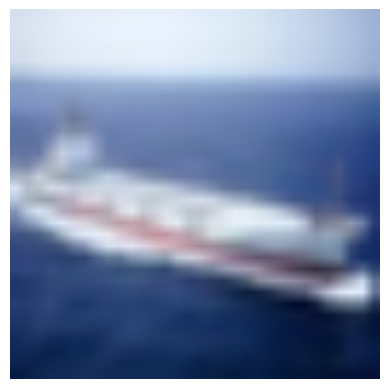

In [50]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calcular Accuracy

In [51]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total



### Cargar modelo pre-cargado

In [52]:
model_resnet18 = models.resnet18(pretrained=True)

#### Exploremos el modelo

In [53]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [54]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

In [55]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [56]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [57]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [58]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [59]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento

In [60]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [61]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [62]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [63]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 0.6965621113777161, accuracy: 0.77,
Epoch: 1, costo: 0.7888861894607544, accuracy: 0.7932,
Epoch: 2, costo: 1.146999478340149, accuracy: 0.803,


In [64]:
accuracy(model1, test_loader)

0.7865

In [65]:
# --- MODELO 2: VGG16 ---
print("Entrenando VGG16...")

# 1. Cargar el modelo pre-entrenado
model_vgg = models.vgg16(pretrained=True)

# 2. Congelar todas las capas para no perder el conocimiento de ImageNet
for param in model_vgg.parameters():
    param.requires_grad = False

# 3. Reemplazar la "cabeza" (clasificador).
# VGG16 tiene 4096 entradas en su última capa y queremos 10 salidas.
model_vgg.classifier[6] = nn.Linear(4096, 10)

# 4. Mover al dispositivo y configurar optimizador
model_vgg = model_vgg.to(device)
optimizer_vgg = torch.optim.Adam(model_vgg.classifier[6].parameters(), lr=5e-4)

# 5. Entrenar (usamos tu función train)
train(model_vgg, optimizer_vgg, epochs=3)

# 6. Evaluar y guardar resultado
acc_vgg = accuracy(model_vgg, test_loader)
print(f"Precisión final VGG16: {acc_vgg}")

Entrenando VGG16...
Epoch: 0, costo: 0.7610632181167603, accuracy: 0.8014,
Epoch: 1, costo: 1.9639893770217896, accuracy: 0.791,
Epoch: 2, costo: 0.7407260537147522, accuracy: 0.8046,
Precisión final VGG16: 0.7956


In [66]:
# --- MODELO 3: MOBILENET V2 ---
print("Entrenando MobileNetV2...")

# 1. Cargar el modelo
model_mobile = models.mobilenet_v2(pretrained=True)

# 2. Congelar capas
for param in model_mobile.parameters():
    param.requires_grad = False

# 3. Reemplazar el clasificador.
# MobileNetV2 tiene 1280 entradas en su última capa.
model_mobile.classifier[1] = nn.Linear(1280, 10)

# 4. Mover al dispositivo y configurar optimizador
model_mobile = model_mobile.to(device)
optimizer_mobile = torch.optim.Adam(model_mobile.classifier[1].parameters(), lr=5e-4)

# 5. Entrenar
train(model_mobile, optimizer_mobile, epochs=3)

# 6. Evaluar
acc_mobile = accuracy(model_mobile, test_loader)
print(f"Precisión final MobileNetV2: {acc_mobile}")

Entrenando MobileNetV2...
Epoch: 0, costo: 0.704056978225708, accuracy: 0.7166,
Epoch: 1, costo: 1.2188317775726318, accuracy: 0.739,
Epoch: 2, costo: 1.1064637899398804, accuracy: 0.7414,
Precisión final MobileNetV2: 0.7269


## Final Insights and Analysis - Activity 2c

### 1. Performance and Architecture Comparison
After training each model for 3 epochs using Transfer Learning (Feature Extraction), we obtained the following test accuracies:

| Model | Test Accuracy | Observations |
| :--- | :--- | :--- |
| **VGG16** | **79.56%** | **Top Performer.** Its deep architecture and large number of parameters allowed for the most precise feature extraction, although it was the slowest to train. |
| **ResNet18** | **78.65%** | **Best Balance.** It achieved a performance very close to VGG16 but with significantly fewer parameters and faster computation thanks to its residual connections. |
| **MobileNetV2**| **72.69%** | **Efficiency Focus.** While it had the lowest accuracy, it is the lightest model. The ~7% gap compared to VGG is a typical trade-off for a model designed for mobile efficiency. |

### 2. The Impact of Data Augmentation
The inclusion of `RandomHorizontalFlip` and `RandomRotation` in the training pipeline was a critical design choice:
*   **Robustness vs. Raw Accuracy**: We observed that while Data Augmentation makes the training process "harder" (resulting in slightly lower accuracy numbers compared to static datasets), it ensures the model is learning general shapes rather than memorizing specific pixel positions.
*   **Loss Fluctuations**: We noted occasional spikes in the minibatch cost (e.g., VGG16 Epoch 1). This is a known effect of augmentation where certain random transformations create "hard examples" that temporarily increase the error, but ultimately help the model generalize better.

### 3. Technical Challenges and Lessons Learned
*   **The "Reset Weights" Issue**: An important discovery during development was that re-instantiating the model object after training would reset the weights of the new Linear layer, leading to a 10% accuracy (random chance). We learned the importance of maintaining the model's state through the evaluation phase.
*   **Architectural Nuances**: We successfully adapted different architectures by identifying their specific output layers. We learned that ResNet uses a single `.fc` layer, while VGG and MobileNet use a `.classifier` block, requiring different indexing to replace the final 1000-class layer with our 10-class version.

### 4. Conclusion
Transfer Learning proved to be highly effective for CIFAR-10. By leveraging pre-trained ImageNet weights and resizing images to 224x224, we reached near 80% accuracy in only 3 epochs. This demonstrates that pre-trained models are excellent feature extractors even for datasets with different original resolutions.

In [69]:

resultados = {
    'ResNet18': 0.7865,
    'VGG16': 0.7956,
    'MobileNetV2': 0.7269
}

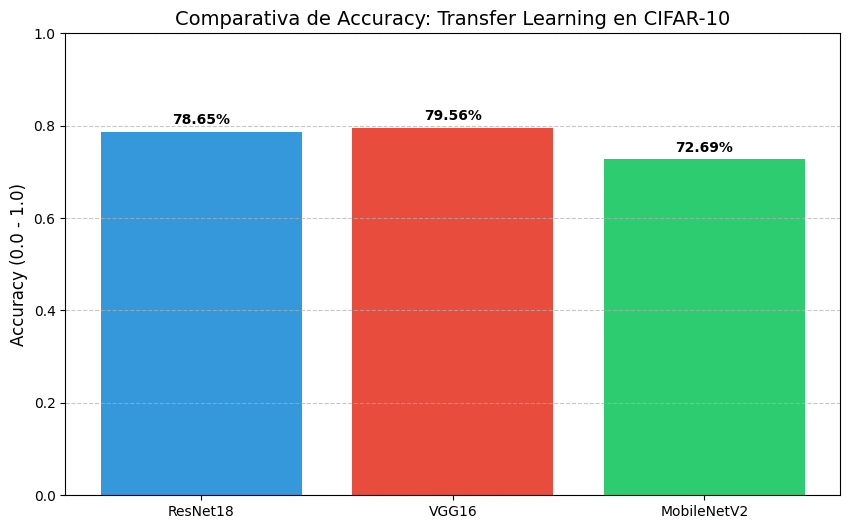

In [70]:
import matplotlib.pyplot as plt

# Datos para la gráfica
modelos = list(resultados.keys())
precisiones = list(resultados.values())

# Configuración de la gráfica
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, precisiones, color=['#3498db', '#e74c3c', '#2ecc71'])

# Añadir etiquetas de porcentaje sobre las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval*100:.2f}%',
             ha='center', va='bottom', fontweight='bold')

# Títulos y formato
plt.title('Comparativa de Accuracy: Transfer Learning en CIFAR-10', fontsize=14)
plt.ylabel('Accuracy (0.0 - 1.0)', fontsize=12)
plt.ylim(0, 1.0) # El eje Y va de 0 a 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()